# NAC coloring search

In this notebook we provide utils to run benchmarks, analyze results and experiment with our code.
As the package is still in development, not all parts must be user friendly, still we try to provide good enough abstraction.

First we define some utility functions for matplotlib,
then we provide utility functions for loading and storing benchmarks results,
after we provide a framework for loading graph classes, defining benchmarks and running them.
Lastly, we provide tools for quick results analyzations.

For some advanced functionality in datasets and running pytest it is necesarry to PyRigi v0.3.0.
Either install it using `pip install pyrigi==0.3.0` or clone it into the project root directory from https://github.com/PyRigi/PyRigi/tree/0.3.0.
The `nac` package itself is completely independent.

In [1]:
from typing import *
from dataclasses import dataclass
from collections import defaultdict, deque
import random
import importlib
from random import Random
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline
from matplotlib.backends import backend_agg
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import networkx as nx
import os
import time
import datetime
import signal
import itertools
import base64

from tqdm import tqdm

import nac as nac
import nac.util
from nac import MonochromaticClassType
from benchmarks import dataset
importlib.reload(nac)
importlib.reload(nac.util)
importlib.reload(dataset)

seed=42

### Benchmarks directory

You can either choose to use our precomputed results or run the benchmarks yourself.
The algorithms take usually tens or hunderes of miliseconds to run,
but there is plenty of graphs and strategies combinations, so times add up.

In [2]:
OUTPUT_DIR_PRECOMPUTED = os.path.join("benchmarks", "precomputed")
OUTPUT_DIR_LOCAL = os.path.join("benchmarks", "local")

OUTPUT_DIR = OUTPUT_DIR_PRECOMPUTED
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Preparation

We define an utility function that allows us to use MatPlotLib figures witout using its internal global state.

In [3]:
# https://stackoverflow.com/a/75898999
from typing import Callable, TypeVar, ParamSpec

P = ParamSpec("P")
T = TypeVar("T")

def copy_doc(wrapper: Callable[P, T]):
    """An implementation of functools.wraps."""

    def decorator(func: Callable) -> Callable[P, T]:
        func.__doc__ = wrapper.__doc__
        return func

    return decorator

In [4]:
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def fig_size(
        width: float = 398.33858,
        fraction: float = 2.5,
        subplots: Tuple[int,int] = (1, 1),
    ):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


@copy_doc(plt.figure)
def figure(num: Any = 1, *args, **kwargs) -> Figure:
    """Creates a figure that is independent on the global plt state"""
    fig = Figure(*args, **kwargs)
    def show():
        manager = backend_agg.new_figure_manager_given_figure(num, fig)
        display(
            manager.canvas.figure,
            metadata=backend_inline._fetch_figure_metadata(manager.canvas.figure),
        )
        manager.destroy()
    fig.show = show
    return fig

def export_figure_to_pdf(
    fig: Figure,
    dataset: str,
    mode: Literal["first", "all"],
    metric: Literal["runtime", "checks"],
    dir: str = "figures",
) -> None:
    os.makedirs(dir, exist_ok=True)
    fig.savefig(os.path.join(dir, f'graph_export_{dataset}_{mode}_{metric}.pdf'), format='pdf', bbox_inches='tight')

def export_standard_figures_to_pdf(
    dataset: str,
    figs: Sequence[Figure],
    dir: str = "figures",
) -> None:
    configs = (
        ("first", "runtime"),
        ("first", "chekcs"),
        ("all",   "runtime"),
        ("all",   "chekcs"),
    )
    for fig, (mode, metric) in tqdm(zip(figs, configs)):
        export_figure_to_pdf(fig, dataset, mode, metric, dir)

# import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_theme("paper")
plt.rcParams.update(
    { "text.usetex": True, } if os.uname()[1] != "msi" else {}
    | {
        "font.family": "serif",
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 8,
        "figure.titlesize": 20,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
)

# Loading graph classes

In this section we load graphs that can be later used for running benchmarks.
The graphs are not in any specified order and they differ in size ranges.
Graphs are stored in the `graph6` format in the `graphs_store` directory.

In [5]:
class LazyList[T](List[T]):
    """
    Delays list creation until first request
    """
    def __init__(self, generator: Callable[[], Iterable[T]]):
        self._generator = generator
        self._list: List[T] | None = None

    def _get_list(self) -> List[T]:
        if self._list is None:
            self._list = list(self._generator())
        return self._list

    def __iter__(self) -> Iterator[T]:
        return self._get_list().__iter__()

    def __len__(self) -> int:
        return self._get_list().__len__()

    def __getitem__(self, i: SupportsIndex) -> T:
        return self._get_list().__getitem__(i)

In [6]:
class Graphs:
    """
    Randomly generated laman graphs of various sizes
    """
    laman_random = LazyList(lambda: dataset.load_laman_random_graphs())
    """
    Graphs with no 3 nor 4 cycles up to 42 vertices
    """
    no_3_nor_4_cycles = LazyList(lambda: dataset.load_no_3_nor_4_cycle_graphs())
    """
    Graps generated according to yet unpublished formulla that garanties that these graphs should either have no or small number of NAC-colorings
    """
    sparse_with_few_colorings = LazyList(lambda: dataset.load_sparse_with_few_colorings_graphs())
    """
    Globally rigid graphs
    """
    globally_rigid = LazyList(lambda: dataset.load_globally_rigid_graphs())

    """
    Loads all the Laman graphs of the given size, pregenerated files allow the range of [5, 11]
    """
    def load_all_laman(vertex_no: int) -> List[nx.Graph]:
        return list(dataset.load_laman_all(vertices_no=vertex_no))

# Storing and loading benchmark results

Each row represents performance of a graph with a given strategy.
The difference between the first and all variant is that
in the all variants we search for all NAC-colorings,
but in the first variant we search only.

The export CSV columns are:
- `graph` - base64 encoded bytes of graph6 encoded graph
- `dataset` - class of the graph, `laman_random`, `laman_deg_3_plus`, `no_3_nor_4_cycles`, ...
- `vertex_no` - the number of vertices of the graph
- `edge_no` - the number of edges of the graph
- `triangle_components_no` - the number of triangle components of the graph
- `monochromatic_classes_no` - the number of monochromatic classes of the graph
- `relabel` - relabel strategy (relabels vertices before the main algorithm is run, here we have only `none` or `random`)
- `split` - splitting strategy
- `merge` - merging strategy
- `subgraph_size` - the target initial size of subgraphs in monochromatic components
- `used_monochromatic_classes` - if monochromatic classes were used to run the test, `False` means triangle components were used
- `nac_any_finished` - if any of the tests finished in time
- `nac_{first|all}_coloring_no` - the number of NAC-colorings of the graph, for the first variant limited to 1
- `nac_{first|all}_mean_time` - the time required to find first/all NAC-colorings in milliseconds
- `nac_{first|all}_rounds` - the number of rounds used to run the benchmarks
- `nac_{first|all}_check_cycle_mask` - the number of cycle mask checks performed
- `nac_{first|all}_check_is_NAC` - the number of `IsNACColorng` checks performed

In [7]:
COLUMNS: List[str] = [
    "graph",
    "dataset",
    "vertex_no",
    "edge_no",
    "triangle_components_no",
    "monochromatic_classes_no",
    "relabel",
    "split",
    "merging",
    "subgraph_size",
    "used_monochromatic_classes",
    "nac_any_finished",
    "nac_first_coloring_no",
    "nac_first_mean_time",
    "nac_first_rounds",
    "nac_first_check_is_NAC",
    "nac_first_check_cycle_mask",
    "nac_all_coloring_no",
    "nac_all_mean_time",
    "nac_all_rounds",
    "nac_all_check_is_NAC",
    "nac_all_check_cycle_mask",
]

@dataclass
class MeasurementResult:
    graph: str
    dataset: str
    vertex_no: int
    edge_no: int
    triangle_components_no: int
    monochromatic_classes_no: int
    relabel: str
    split: str
    merging: str
    subgraph_size: int
    used_monochromatic_classes: bool
    nac_any_finished: bool
    nac_first_coloring_no: Optional[int]
    nac_first_mean_time: Optional[int]
    nac_first_rounds: Optional[int]
    nac_first_check_is_NAC: Optional[int]
    nac_first_check_cycle_mask: Optional[int]
    nac_all_coloring_no: Optional[int]
    nac_all_mean_time: Optional[int]
    nac_all_rounds: Optional[int]
    nac_all_check_is_NAC: Optional[int]
    nac_all_check_cycle_mask: Optional[int]

    def to_list(self) -> List:
        return [
            self.graph,
            self.dataset,
            self.vertex_no,
            self.edge_no,
            self.triangle_components_no,
            self.monochromatic_classes_no,
            self.relabel,
            self.split,
            self.merging,
            self.subgraph_size,
            self.used_monochromatic_classes,
            self.nac_any_finished,
            self.nac_first_coloring_no,
            self.nac_first_mean_time,
            self.nac_first_rounds,
            self.nac_first_check_is_NAC,
            self.nac_first_check_cycle_mask,
            self.nac_all_coloring_no,
            self.nac_all_mean_time,
            self.nac_all_rounds,
            self.nac_all_check_is_NAC,
            self.nac_all_check_cycle_mask,
        ]

In [8]:
def toBenchmarkResults(data: List[MeasurementResult] = []) -> pd.DataFrame:
    return pd.DataFrame(
        [x.to_list() for x in data],
        columns=COLUMNS,
    )

In [9]:
def graph_to_id(graph: nx.Graph) -> str:
    return base64.standard_b64encode(nx.graph6.to_graph6_bytes(graph, header=False).strip()).decode()

def graph_from_id(id: str) -> nx.Graph:
    return nac.util.NiceGraph(nx.graph6.from_graph6_bytes(base64.standard_b64decode(id)))

# Strategies

The interface of the NAC-coloring search function looks like this:
```python
def NAC_colorings(
    graph: nx.Graph,
    algorithm: str = "subgraphs",
    relabel_strategy: str = "none",
    monochromatic_class_type: MonochromaticClassType = MonochromaticClassType.MONOCHROMATIC,
    use_decompositions: bool = True,
    use_has_coloring_check: bool = True,
    seed: int | None = None,
) -> Iterable[NACColoring]:
```

The relabel strategy is either `"none"` or `"random"`.
`MonochromaticClassType` types are `MONOCHROMATIC` that creates monochromatic classes as described in the paper,
`TRIANGLES` that finds only triangle connected components and
`EDGES` that uses no monochromatic classes optimization.
The `use_decompositions` switch is responsible for enabling checks for articulation points and related decomposition into blocks.
The `use_has_coloring_check` runs some polynomial checks if a NAC-coloring can exist. If not, the whole search is skipped.
`seed` is used by strategies internally as only pseudo random number generators are used.

The most important field is the `algorithm` field.
Possible values are:
- `"naive"` - runs naive algorithm
- `"cycles"` - runs naive algorithm improved by cycles detection
- `"subgraphs"` - runs so far optimal algorithm for larger graphs based on subgraph decomposition
- `"subgraphs-{merge_strategy}-{split_strategy}-{size_of_subgraphs}"` - runs the specified strategy combination with subgraph decomposition

In our code strategies are represented as four-tupples.

In [10]:
class Promising:
    RELABELING = [
        "none",
        "random",
    ]
    SPLITTING = [
        "none",
        "neighbors",
        "neighbors_degree",
    ]
    MERGE = [
        "linear",
        "shared_vertices",
    ]
    # This is not optimal for every graph, but does not hurt performance significantly
    SIZES = [6]

    strategies = list(itertools.product(
        RELABELING, SPLITTING, MERGE, SIZES,
    ))
print(f"Strategies: {len(Promising.strategies)}")

Strategies: 12


In [11]:
def create_subgraph_strategy(param: Tuple[str, str, str, int]) -> Tuple[str, str]:
    relabel, split, merge, subgraph = param
    algo_name = "subgraphs-{}-{}-{}".format( merge, split, subgraph)
    return (relabel, algo_name)

In case you want to play with the notebook we predefined some strategies as example.

In [12]:
STRATEGY_NONE_LINEAR = create_subgraph_strategy(("", "none", "linear", 6))[1]
STRATEGY_NEIGHBORS_LINEAR = create_subgraph_strategy(("", "neighbors", "linear", 6))[1]
STRATEGY_NEIGHBORS_DEGREE_LINEAR = create_subgraph_strategy(("", "neighbors_degree", "linear", 6))[1]

list(nac.NAC_colorings(
    graph=nx.path_graph(4),
    algorithm=STRATEGY_NEIGHBORS_DEGREE_LINEAR,
))

[([(2, 3)], [(0, 1), (1, 2)]),
 ([(1, 2)], [(0, 1), (2, 3)]),
 ([(1, 2), (2, 3)], [(0, 1)]),
 ([(0, 1)], [(1, 2), (2, 3)]),
 ([(0, 1), (2, 3)], [(1, 2)]),
 ([(0, 1), (1, 2)], [(2, 3)])]

### File storage management

In [13]:
_BENCH_FILE_START = "bench_res"

def _find_latest_record_file(
    prefix: str,
    dir: str,
) -> str | None:
    def filter_cond(name: str) -> bool:
        return name.startswith(prefix) and name.endswith(".csv")
    data = sorted(filter(filter_cond, os.listdir(dir)), reverse=True)

    if len(data) == 0:
        return None
    file_name = data[0]
    return file_name

def load_records(file_name: str | None = None, dir = OUTPUT_DIR, allow_output: bool = False) -> pd.DataFrame:
    """
    Loads the results from the last run or the run specified by `file_name` in the `dir` given.
    """
    if file_name == None:
        file_name = _find_latest_record_file(_BENCH_FILE_START, dir)
        if file_name is None:
            if allow_output:
                print("No file with results found!")
            return toBenchmarkResults()
        print(f"Found file: {file_name}")

    path = os.path.join(dir, file_name)
    df = pd.read_csv(path)
    df = df[COLUMNS]
    return df

def store_results(
    df: pd.DataFrame,
    file_name: str | None = None,
    dir = OUTPUT_DIR,
) -> str:
    """
    Stores results in the given file
    """
    if file_name is None:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_name = f"{_BENCH_FILE_START}_{current_time}.csv"
    path = os.path.join(dir, file_name)

    # Filter out outliers (over 60s) that run when I put my laptor into sleep mode
    df = df.query("nac_all_mean_time < 60_000 and nac_first_mean_time < 60_000")

    df.to_csv(path, header=True, index=False)
    return file_name

def update_stored_data(dfs: List[pd.DataFrame] = [], head_loaded: bool = True) -> pd.DataFrame:
    df = load_records()
    if head_loaded:
        display(df)
    if len(dfs) != 0:
        df = pd.concat((df, pd.concat(dfs)))
    df = df.drop_duplicates(
        subset=["graph", "dataset", "split", "relabel", "merging", "subgraph_size", "used_monochromatic_classes"],
        keep='last',
    )
    store_results(df)
    return df

### Running and recording benchmarks

In [14]:
class BenchmarkTimeoutException(Exception):
    def __init__(self, msg: str = "The benchmark timed out", *args, **kwargs):
        super().__init__(msg, *args, **kwargs)


def with_timeout[**T, R, D](function: Callable[T, R], time_limit: int | None, default: D) -> Callable[T, R|D]:
    """
    Stops the function execution after a specified timeout in seconds is reached.
    """
    if time_limit is None:
        return function

    def impl(*args: P.args, **kwargs: P.kwargs):
        try:
            # signals are not exact, but generally work
            def timeout_handler(signum, frame):
                raise BenchmarkTimeoutException()
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(time_limit)

            res = function(*args, **kwargs)

            signal.alarm(0)
            return res
        except BenchmarkTimeoutException:
            return default
    return impl

In [15]:
@dataclass
class MeasuredRecord:
    """
    Pepresents measurement result of a single type
    """
    time_sum: int = 0
    coloring_no: int = 0
    rounds: int = 0
    checks_is_NAC: int = 0
    checks_cycle_mask: int = 0

    @property
    def mean_time(self) -> int:
        if self.rounds == 0:
            return 0
        return int(self.time_sum / self.rounds * 1000)

@dataclass
class MeasuredData:
    """
    Groups measurement results for both the types of tests
    """
    first: Optional[MeasuredRecord]
    all: Optional[MeasuredRecord]

The cell bellow contains the heart of the benchmark that does the technical theoretically non-interesting operations.

In [16]:
def nac_benchmark_core(
    graph: nx.Graph,
    rounds: int,
    first_only: bool,
    strategy: Tuple[str, str],
    use_monochromatic_classes: bool,
    time_limit: int,
    seed: int | None = 42,
) -> MeasuredData:
    """
    Runs benchmarks for NAC coloring search
    Returns results grouped by relabel, split, merge and subgraph size strategies
    """

    if use_monochromatic_classes:
        monochromatic_class_type = nac.MonochromaticClassType.MONOCHROMATIC
    else:
        monochromatic_class_type = nac.MonochromaticClassType.TRIANGLES

    result = MeasuredData(None, None)
    rand = random.Random(seed)

    def find_colorings():
        start_time = time.time()

        itr = iter(
            nac.NAC_colorings(
                graph=graph,
                algorithm=strategy[1],
                relabel_strategy=strategy[0],
                monochromatic_class_type=monochromatic_class_type,
                seed=rand.randint(0, 2**30),
            )
        )

        first_col = next(itr, None)
        first_time = time.time()

        if result.first is None:
            result.first = MeasuredRecord()
        result.first = MeasuredRecord(
            time_sum=result.first.time_sum + first_time - start_time,
            coloring_no=0 if first_col is None else 1,
            rounds=result.first.rounds + 1,
            checks_is_NAC=nac.NAC_check_called()[0],
            checks_cycle_mask=nac.NAC_check_called()[1],
        )

        if first_only:
            return

        j = 0
        for j, coloring in enumerate(itr): pass
        end_time = time.time()

        if result.all is None:
            result.all = MeasuredRecord()
        result.all = MeasuredRecord(
            time_sum=result.all.time_sum + end_time - start_time,
            coloring_no=j+1+1,
            rounds=result.all.rounds + 1,
            checks_is_NAC=nac.NAC_check_called()[0],
            checks_cycle_mask=nac.NAC_check_called()[1],
        )

    def run() -> None:
        [find_colorings() for _ in range(rounds)]

    with_timeout(
        run,
        time_limit=time_limit*rounds,
        default=None,
    )()

    return result

This cell is just boilerplate code for creating the measurement result object

In [17]:
def create_measurement_result(
    graph: nx.Graph,
    dataset_name: str,
    trianlge_classes: int,
    monochromatic_classes: int,
    nac_first: Optional[MeasuredRecord],
    nac_all: Optional[MeasuredRecord],
    relabel_strategy: str,
    split_strategy: str,
    merge_strategy: str,
    subgraph_size: int,
    used_monochromatic_classes: bool,
) -> MeasurementResult:
    vertex_no = nx.number_of_nodes(graph)
    edge_no = nx.number_of_edges(graph)

    nac_any_finished = (nac_first or nac_all) is not None
    nac_first = nac_first or MeasuredRecord()
    nac_all   = nac_all   or MeasuredRecord()

    return MeasurementResult(
        graph=graph_to_id(graph),
        dataset=dataset_name,
        vertex_no=vertex_no,
        edge_no=edge_no,
        triangle_components_no=trianlge_classes,
        monochromatic_classes_no=monochromatic_classes,
        relabel=relabel_strategy,
        split=split_strategy,
        merging=merge_strategy,
        subgraph_size=subgraph_size,
        used_monochromatic_classes=used_monochromatic_classes,
        nac_any_finished=nac_any_finished,
        nac_first_coloring_no=nac_first.coloring_no,
        nac_first_mean_time=nac_first.mean_time,
        nac_first_rounds=nac_first.rounds,
        nac_first_check_is_NAC=nac_first.checks_is_NAC,
        nac_first_check_cycle_mask=nac_first.checks_cycle_mask,
        nac_all_coloring_no=nac_all.coloring_no,
        nac_all_mean_time=nac_all.mean_time,
        nac_all_rounds=nac_all.rounds,
        nac_all_check_is_NAC=nac_all.checks_is_NAC,
        nac_all_check_cycle_mask=nac_all.checks_cycle_mask,
    )

This cell serves as the main interface for running benchmarks, see the function's doc string.
It is compatible only with subgraph decomposition based strategies, for the naive search other functions have to be written.

In [18]:
def measure_for_graph_class(
    dataset_name: str,
    graphs: Iterable[nx.Graph],
    all_max_vertex_no: int,
    rounds:int,
    graph_timeout: int,
    use_monochromatic_classes: bool = True,
    df_seen: pd.DataFrame | None = load_records(),
    save_every: int | None = 5*60,
) -> pd.DataFrame:
    """
    Runs benchmarks for the given graph class.

    Parameters:
        dataset_name: Name of the dataset stored in the output csv
        graphs: Iterable of graphs to benchmark
        all_max_vertex_no: Maximum vertex number to search for all NAC-colorings
        rounds: Number of rounds to run for each graph
        graph_timeout: Timeout for each graph in seconds
        use_monochromatic_classes: Whether to use monochromatic classes or tiriangle connected components
        df_seen: Dataframe with already measured data, so already tried graphs and strategies can be skipped
        save_every: save progress every number of seconds
    """

    dataset_name = dataset_name.replace(" ", "_").lower()
    if df_seen is None:
        df_seen = toBenchmarkResults()
    df_seen = df_seen.query(f"dataset == '{dataset_name}'")

    results: List[MeasurementResult] = []
    all_results: List[MeasurementResult] = []

    last_save = time.time()

    for graph in tqdm(graphs):
        # this would be a functin if python would not have broken scoping
        if save_every is not None:
            now = time.time()
            if now - last_save > save_every:
                all_results.extend(results)
                df = toBenchmarkResults(results)
                update_stored_data([df], head_loaded=False)
                results = []
                last_save = now


        all_colorings = all_max_vertex_no >= graph.number_of_nodes()
        trianlge_classes = len(nac.find_monochromatic_classes(graph=graph, class_type=MonochromaticClassType.TRIANGLES)[1])
        monochromatic_classes = len(nac.find_monochromatic_classes(graph=graph, class_type=MonochromaticClassType.MONOCHROMATIC)[1])

        graph_id = graph_to_id(graph)
        df_graph = df_seen.query(f"graph == '{graph_id}'")

        for strategy in Promising.strategies:
            # skip test that already run
            if len(df_graph.query(f"relabel == '{strategy[0]}' and split == '{strategy[1]}' and merging == '{strategy[2]}' and subgraph_size == {strategy[3]} and used_monochromatic_classes == {use_monochromatic_classes}")) > 0:
                continue

            try:
                search_res = nac_benchmark_core(
                    graph,
                    rounds=rounds,
                    first_only=not all_colorings,
                    strategy=create_subgraph_strategy(strategy),
                    use_monochromatic_classes=use_monochromatic_classes,
                    time_limit=graph_timeout,
                )

                relabel, split, merge, subgraph_size = strategy
                res = create_measurement_result(
                    graph=graph,
                    dataset_name=dataset_name,
                    trianlge_classes=trianlge_classes,
                    monochromatic_classes=monochromatic_classes,
                    nac_first=search_res.first,
                    nac_all=search_res.all,
                    relabel_strategy=relabel,
                    split_strategy=split,
                    merge_strategy=merge,
                    subgraph_size=subgraph_size,
                    used_monochromatic_classes=use_monochromatic_classes,
                )
                results.append(res)
            except Exception as e:
                print("Exception:", e)

    all_results.extend(results)
    df = toBenchmarkResults(results)
    update_stored_data([df], head_loaded=False)

    df = toBenchmarkResults(all_results)
    df = df.sort_values(by=["nac_all_mean_time", "nac_first_mean_time"])
    return df

Found file: bench_res_2024-12-01_18-48-38.csv


# Running benchmarks

You can run any of these cells by changing the condition and running the cell. As described above, benchmarks take long to run because each graph is run 3 times for each enabled strategy.
Each run on a graph takes tens or hundreds of milliseconds to run and that adds up.
There is autosave enabled that stores progress every 5 minutes.
Do not forget to change `OUTPUT_DIR` at the beginning of the notebook otherwise the tests will be skipped as they are already precomputed for you.

### Laman Random

In [19]:
if False:
    measure_for_graph_class(
        "Laman random",
        Graphs.laman_random,
        all_max_vertex_no=16,
        rounds=3,
        graph_timeout=3,
        save_every=5,
    )

### No 3 nor 4 cycles

In [20]:
if False:
    display(pd.Series([g.number_of_nodes() for g in Graphs.no_3_nor_4_cycles]).value_counts())
    df_no_3_nor_4_cycles = measure_for_graph_class(
        "No 3 nor 4 cycles",
        Graphs.no_3_nor_4_cycles,
        all_max_vertex_no=0,
        rounds=3,
        graph_timeout=3,
    )

### Sparse with few NAC-colorings

In [21]:
if False:
    measure_for_graph_class(
        "few_colorings",
        Graphs.sparse_with_few_colorings,
        all_max_vertex_no=0,
        rounds=3,
        graph_timeout=3,
    )

### Globally rigid

In [22]:
if False:
    measure_for_graph_class(
        "globally_rigid",
        Graphs.globally_rigid,
        all_max_vertex_no=0,
        rounds=3,
        graph_timeout=3,
    )

### Triangle components

In [23]:
if False:
    groupped = load_records().query("nac_any_finished == True and nac_first_coloring_no == 0 and triangle_components_no > 1")[['graph', 'dataset']].drop_duplicates().groupby('dataset')

    for dataset_name in groupped.groups.keys():
        group = groupped.get_group(dataset_name)

        print(dataset_name, len(group))
        measure_for_graph_class(
            dataset_name,
            [nx.graph6.from_graph6_bytes(id) for id in group["graph"]],
            all_max_vertex_no=1,
            rounds=3,
            graph_timeout=5,
            # This is the main difference
            use_monochromatic_classes=False,
        )

# Analytics

In this section we provide a framework for plotting results of the previous benchmarks.

**All the chars plotted bellow in this section are created from runs with more than one monochromatic classes.**
If that is the case, the results can be obtained immediately as the answer is trivial.
Therefore, we filter them out.

The first group of graphs show the time required to find
a first/all NAC coloring based on the number of vertices or the number of monochromatic classes.
In one row you can see mean and median plots with lines for each strategy.
Graphs show mean and median, but it is not hard to add additional aggregation function to the framework.

In [24]:
df_analytics = load_records()

df_analytics = df_analytics.query("nac_any_finished == True")
df_analytics = df_analytics.assign(split_merging=lambda x: x["split"] + " & " + x["merging"])

df_analytics_no_nac = df_analytics.query("nac_first_coloring_no == 0 and triangle_components_no > 1 and used_monochromatic_classes == False")
df_analytics = df_analytics.query("monochromatic_classes_no > 1")

# display(df_analytics.info())
print("Records:", df_analytics.shape[0], "graphs:", df_analytics["graph"].nunique())
display(df_analytics.columns)
display(list(df_analytics["dataset"].unique()))
display(list(df_analytics["relabel"].unique()))
display(list(df_analytics["split"].unique()))
display(list(df_analytics["merging"].unique()))

Found file: bench_res_2024-12-01_18-48-38.csv
Records: 1490 graphs: 136


Index(['graph', 'dataset', 'vertex_no', 'edge_no', 'triangle_components_no',
       'monochromatic_classes_no', 'relabel', 'split', 'merging',
       'subgraph_size', 'used_monochromatic_classes', 'nac_any_finished',
       'nac_first_coloring_no', 'nac_first_mean_time', 'nac_first_rounds',
       'nac_first_check_is_NAC', 'nac_first_check_cycle_mask',
       'nac_all_coloring_no', 'nac_all_mean_time', 'nac_all_rounds',
       'nac_all_check_is_NAC', 'nac_all_check_cycle_mask', 'split_merging'],
      dtype='object')

['laman_random']

['none', 'random']

['none', 'neighbors', 'neighbors_degree']

['linear', 'shared_vertices']

In [25]:
def _group_and_plot(
    df: pd.DataFrame,
    axs: List[plt.Axes],
    x_column: Literal["vertex_no", "monochromatic_classes_no"],
    based_on: Literal["relabel", "split", "merging"],
    value_columns: List[Literal["nac_first_mean_time", "nac_all_mean_time"]],
):
    aggregations = ["mean", "median", "3rd quartile"]
    df = df.loc[:, [x_column, based_on, *value_columns]]
    groupped = df.groupby([x_column, based_on])

    for ax, aggregation in zip(axs, aggregations):
        match aggregation:
            case "mean":
                aggregated = groupped.mean()
            case "median":
                aggregated = groupped.median()
            case "3rd quartile":
                aggregated = groupped.quantile(.75)

        aggregated = aggregated.reorder_levels([based_on, x_column], axis=0)

        for name in aggregated.index.get_level_values(based_on).unique():
            data = aggregated.loc[name]
            for value_column in value_columns:
                title = ",".join([name, value_column]) if len(value_columns) > 1 else name
                ax.plot(data.index, data[value_column], label=title)

        rename_based_on = {
            "vertex_no": "Vertices",
            "triangle_components_no": "Triangle components",
            "monochromatic_classes_no": "Monochromatic classes",
        }

        # ax.set_title(f"{rename_based_on[x_column]} {based_on} ({aggregation})")
        # ax.set_title(f"{rename_based_on[x_column]} ({aggregation})")
        ax.set_title(f"{aggregation.capitalize()}")
        ax.set_yscale("log")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xlabel(rename_based_on[x_column])
        ax.legend(loc='lower right')

def plot_frame(
    title: str,
    df: pd.DataFrame,
    ops_value_columns_sets = [
        [ "nac_first_mean_time", ],
        [ "nac_first_check_cycle_mask", ],
        [ "nac_all_mean_time", ],
        [ "nac_all_check_cycle_mask", ],
    ],
    ops_x_column = ["vertex_no", "monochromatic_classes_no",],
    ops_based_on = [
        #  "relabel",
        # "split",
        # "merging",
        "split_merging",
    ],
    ops_aggregation = ["mean", "median",], #  "3rd quartile",
) -> List[Figure]:
    print(f"Plotting {df.shape[0]} records...")
    figs = []

    title_rename = {
        "nac_first_mean_time": "First NAC-coloring, Runtime",
        "nac_first_check_cycle_mask": "First NAC-coloring, Checks number",
        "nac_all_mean_time": "All NAC-colorings, Runtime",
        "nac_all_check_cycle_mask": "All NAC-colorings, Checks number",
    }

    for value_columns in ops_value_columns_sets:
        local_df = df[(df[value_columns] != 0).all(axis=1)]
        if local_df.shape[0] == 0:
            continue

        nrows = len(ops_x_column) * len(ops_based_on)
        ncols = len(ops_aggregation)
        fig = figure(
            nrows * ncols,
            figsize=fig_size(subplots=(nrows, ncols)),
            layout='constrained',
        )
        title_detail = " | ".join(title_rename[value_column] for value_column in value_columns)
        # fig.suptitle(f"{title} ({title_detail})", fontsize=20)
        fig.suptitle(f"{title} ({title_detail})")
        figs.append(fig)

        row = 0
        for x_column in ops_x_column:
            for based_on in ops_based_on:
                axs = [
                    fig.add_subplot(nrows, ncols, i+ncols*row+1)
                    for i in range(len(ops_aggregation))]
                _group_and_plot(local_df, axs, x_column, based_on, value_columns)
                row += 1
    return figs

# [display(fig) for fig in plot_frame("Laman", df_analytics.query("dataset == 'laman'"))]

In [26]:
if False:
    title = 'Laman random'
    dataset_name = 'laman_random'
    figs = [fig for fig in plot_frame(title, df_analytics.query(f"dataset == '{dataset_name}'"))]
    export_standard_figures_to_pdf(dataset_name, figs)
    [display(fig) for fig in figs]

In [27]:
if False:
    title = 'No 3 nor 4 cycles'
    dataset_name = 'no_3_nor_4_cycles'
    figs = [fig for fig in plot_frame(title, df_analytics.query(f"dataset == '{dataset_name}'"))]
    export_standard_figures_to_pdf(dataset_name, figs)
    [display(fig) for fig in figs]

In [28]:
if False:
    [display(fig) for fig in plot_frame("", df_analytics.query("dataset == 'few_colorings'"))]
    title = 'Sparse with few colorings - None'
    dataset_name = ''
    figs = [fig for fig in plot_frame(title, df_analytics.query(f"dataset == '{dataset_name}'"))]
    export_standard_figures_to_pdf(dataset_name, figs)
    [display(fig) for fig in figs]

In [29]:
if True:
    title = 'Globaly rigid'
    dataset_name = 'globaly_rigid'
    figs = [fig for fig in plot_frame(title, df_analytics.query(f"dataset == '{dataset_name}'"))]
    export_standard_figures_to_pdf(dataset_name, figs)
    [display(fig) for fig in figs]

Plotting 0 records...


0it [00:00, ?it/s]


In [30]:
if False:
    title = 'No NAC-coloring, Triangle-components'
    dataset_name = 'triangle_no_nac'
    figs = [fig for fig in plot_frame(title, df_analytics_no_nac.query("merging == 'linear'"), ops_x_column = ["vertex_no", "triangle_components_no",])]
    export_standard_figures_to_pdf(dataset_name, figs)
    [display(fig) for fig in figs]

## The number of checks needed

This group of graphs compares the number of checks performed by our algorithm and by naive algorithm
using either no monochromatic classes, triangle components or monochromatic classes described in the article.

Unless you change anything, the result is plotted from the whole benchmarks dataset - all the graphs classes are used.
You can add `query("dataset == '...'")` to show the graph for a specific dataset.

The number of `IsNACColoring` checks called compared to
the naive approach without or with triangle/monochromatic classes.

It is expected that the number of `IsNACColoring` checks will be smaller than the `CycleMask` checks as the `CycleMask` checks happen every time, but `IsNACColoring` checks happen only if the previous checks fail.

In [31]:
def _plot_is_NAC_coloring_calls_groups(
    title: str,
    df: pd.DataFrame,
    ax: plt.Axes,
    x_column: Literal["vertex_no", "monochromatic_classes_no"],
    value_columns: List[Literal["nac_first_mean_time", "nac_all_mean_time"]],
    aggregation: Literal["mean", "median", "3rd quartile"],
    legend_rename_dict: Dict[str, str] = {},
):
    df = df.loc[:, [x_column, *value_columns]]
    groupped = df.groupby([x_column])
    match aggregation:
        case "mean":
            aggregated = groupped.mean()
        case "median":
            aggregated = groupped.median()
        case "3rd quartile":
            aggregated = groupped.quantile(.75)

    rename_based_on = {
        "vertex_no": "Vertices",
        "triangle_components_no": "Triangle components",
        "monochromatic_classes_no": "Monochromatic classes",
    }

    # display(aggregated)
    aggregated.plot(ax=ax)
    ax.set_title(f"{title} - {aggregation.capitalize()}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel(rename_based_on[x_column])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [legend_rename_dict[l] for l in labels], loc = 'upper left')

def plot_is_NAC_coloring_calls(
    df: pd.DataFrame,
) -> List[Figure]:
    figs = []

    df = df.query("nac_all_coloring_no != 0").copy()
    print(f"Plotting {df.shape[0]} records...")

    related_columns = ["vertex_no", "edge_no", "triangle_components_no", "monochromatic_classes_no", "nac_all_coloring_no", "nac_all_check_is_NAC", "nac_all_check_cycle_mask"]
    df = df.loc[:, related_columns]
    # this does not help our algorithm to stand out, but the graphs can be drawn more easily

    df["exp_edge_no"]               = 2**df["edge_no"]
    df["exp_triangle_component_no"] = 2**df["triangle_components_no"]
    df["exp_monochromatic_class_no"] = 2**df["monochromatic_classes_no"]

    df["scaled_edge_no"]                  = df["edge_no"]                  /df["nac_all_coloring_no"]
    df["scaled_triangle_component_no"]    = df["triangle_components_no"]   /df["nac_all_coloring_no"]
    df["scaled_monochromatic_class_no"]    = df["monochromatic_classes_no"] /df["nac_all_coloring_no"]
    df["scaled_nac_all_check_cycle_mask"] = df["nac_all_check_cycle_mask"] /df["nac_all_coloring_no"]

    df["inv_edge_no"]                  = df["nac_all_coloring_no"] / df["edge_no"]
    df["inv_triangle_component_no"]    = df["nac_all_coloring_no"] / df["triangle_components_no"]
    df["inv_monochromatic_class_no"]    = df["nac_all_coloring_no"] / df["monochromatic_classes_no"]
    df["inv_nac_all_check_cycle_mask"] = df["nac_all_coloring_no"] / df["nac_all_check_cycle_mask"]
    df["inv_nac_all_check_is_NAC"]     = df["nac_all_coloring_no"] / df["nac_all_check_is_NAC"]

    df["new_edge_no"]                  = df["edge_no"]                  /df["exp_monochromatic_class_no"]
    df["new_triangle_component_no"]    = df["triangle_components_no"]   /df["exp_monochromatic_class_no"]
    df["new_monochromatic_class_no"]    = df["monochromatic_classes_no"] /df["exp_monochromatic_class_no"]
    df["new_nac_all_check_cycle_mask"] = df["nac_all_check_cycle_mask"] /df["exp_monochromatic_class_no"]

    rename_dict = {
        "exp_edge_no": "Naive - edges",
        "exp_triangle_component_no": "Naive - triangle-components",
        "exp_monochromatic_class_no": "Naive - monochromatic classes",
        "nac_all_check_cycle_mask": "Subgraphs - CycleMask",
        "nac_all_check_is_NAC": "Subgraphs - IsNACColoring",

        "scaled_edge_no": "Naive - edges",
        "scaled_triangle_component_no": "Naive - triangle-components",
        "scaled_monochromatic_class_no": "Naive - monochromatic classes",
        "scaled_nac_all_check_cycle_mask": "Subgraphs - CycleMask",

        "inv_edge_no": "Naive - edges",
        "inv_triangle_component_no": "Naive - triangle-components",
        "inv_monochromatic_class_no": "Naive - monochromatic classes",
        "inv_nac_all_check_cycle_mask": "Subgraphs - CycleMask",
        "inv_nac_all_check_is_NAC": "Subgraphs - IsNACColoring",

        "new_edge_no": "Naive - edges",
        "new_triangle_component_no": "Naive - triangle-components",
        "new_monochromatic_class_no": "Naive - monochromatic classes",
        "new_nac_all_check_cycle_mask": "Subgraphs - CycleMask",
    }

    ops_x_column = ["vertex_no", "monochromatic_classes_no",]
    ops_value_groups = [
        ["exp_edge_no",    "exp_triangle_component_no",    "exp_monochromatic_class_no",    "nac_all_check_cycle_mask",        "nac_all_check_is_NAC",],
        # ["scaled_edge_no", "scaled_triangle_component_no", "scaled_monochromatic_class_no", "scaled_nac_all_check_cycle_mask"],
        ["inv_edge_no",    "inv_triangle_component_no",    "inv_monochromatic_class_no",    "inv_nac_all_check_cycle_mask",    "inv_nac_all_check_is_NAC", ],
        # ["new_edge_no",    "new_triangle_component_no",    "new_monochromatic_class_no",    "new_nac_all_check_cycle_mask" ],
    ]
    ops_aggregation = ["mean", "median", ] # "3rd quartile",

    nrows = len(ops_value_groups)
    ncols = len(ops_aggregation)

    for x_column in ops_x_column:
        row = 0
        fig = figure(
            nrows * ncols,
            figsize=fig_size(subplots=(nrows, ncols)),
            layout='constrained',
        )
        fig.suptitle(f"Reduction of CycleMask and IsNACColoring checks against the naive algorithm", fontsize=20)
        figs.append(fig)

        for title, value_columns in zip(
            [
                "The number of checks",
                # "#is_NAC_coloring() calls/#NAC(G)",
                "The number of NAC-colorings / The number of checks",
                # "Count: metric / monochromatic classes number",
            ],
            ops_value_groups,
        ):
            axs = [
                fig.add_subplot(nrows, ncols, i+ncols*row+1)
                for i in range(len(ops_aggregation))]
            for ax, aggregation in zip(axs,ops_aggregation):
                _plot_is_NAC_coloring_calls_groups(title, df, ax, x_column, value_columns, aggregation, legend_rename_dict=rename_dict)
            row += 1

    return figs

Plotting 612 records...


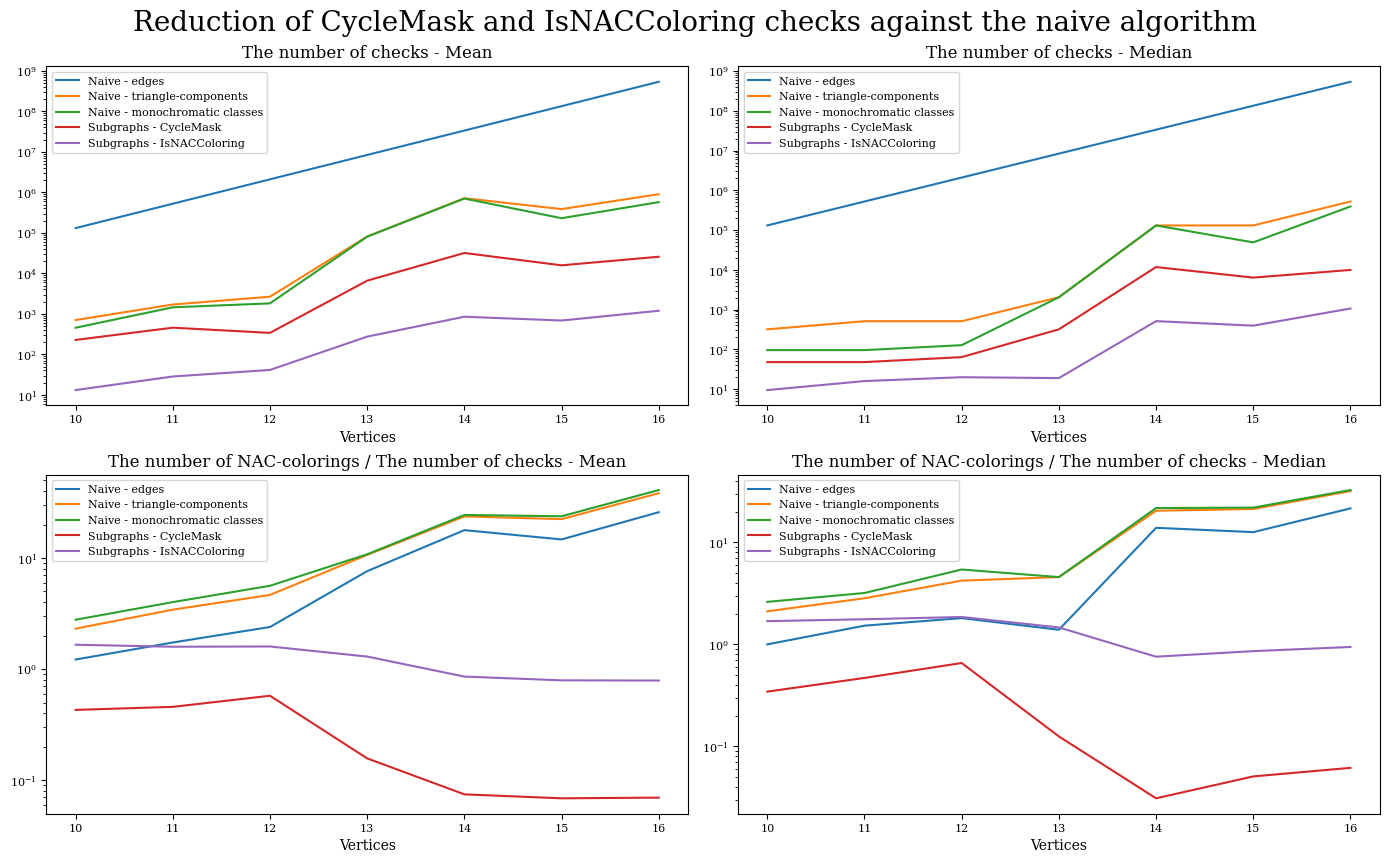

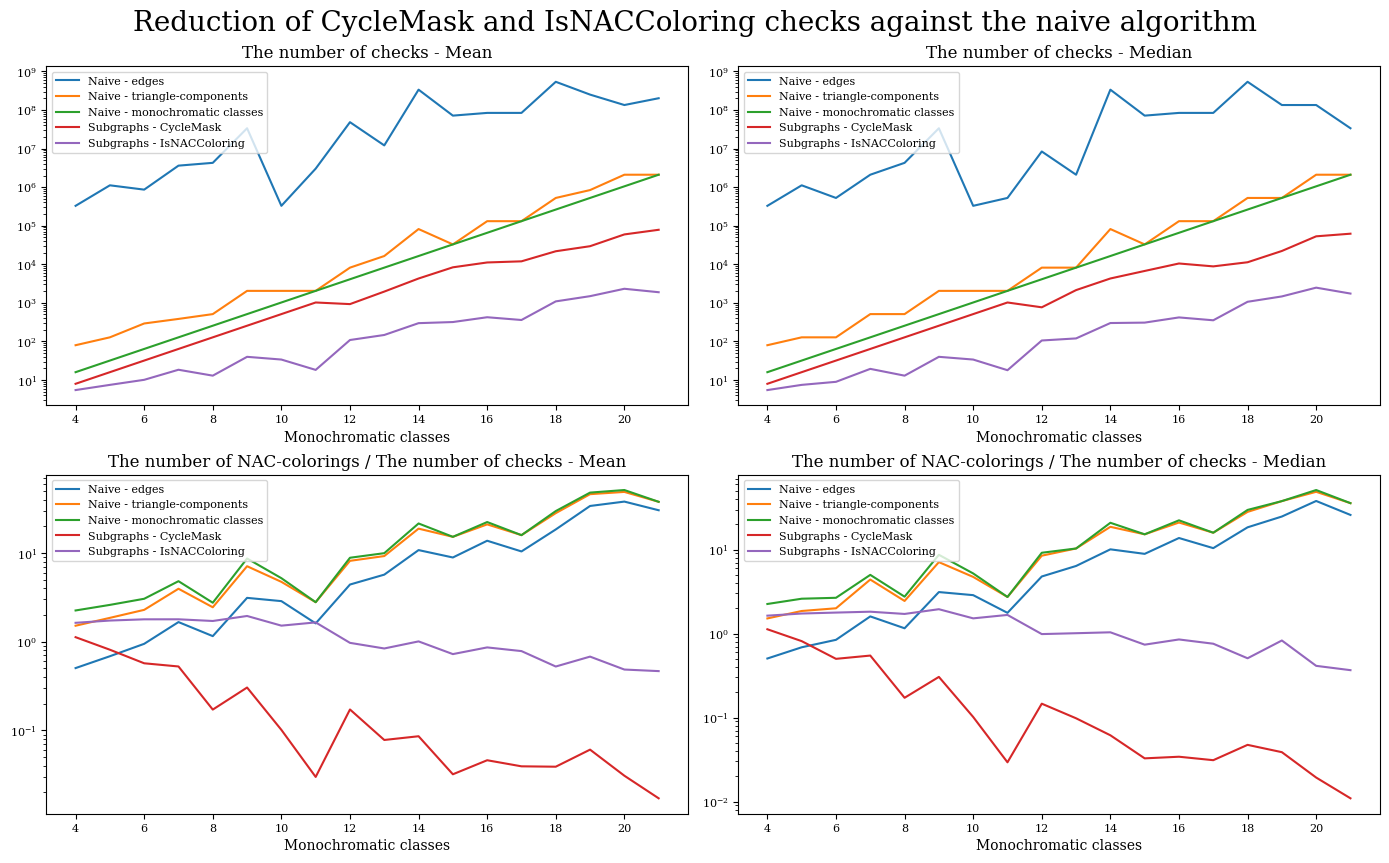

In [32]:
if True:
    figs = [fig for fig in plot_is_NAC_coloring_calls(df_analytics)]
    title = 'All datasets'
    dataset_name = 'check-comparision'
    [export_figure_to_pdf(fig, dataset_name, "first", group_by) for fig, group_by in zip(figs, ["vertices", "monochromatic"])]
    [display(fig) for fig in figs]